# Загрузка и обзор данных

## Импорты

In [20]:
%%chime
import pandas as pd
import numpy as np
import skimpy

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')

# добавлю модуль для звукового оповещения
import chime
chime.theme('mario')
# %load_ext chime

## Загрузка данных

In [5]:
date_columns = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']
df = pd.read_csv('kaggle_startups_train_01.csv', parse_dates=date_columns)

df.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2010-06-24,2011-05-01,2014-12-01,NaT
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-07-30,2012-02-01,2012-02-01,NaT


## Обзор данных

### skimpy и info

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52879 entries, 0 to 52878
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52878 non-null  object        
 1   category_list      50374 non-null  object        
 2   funding_total_usd  42753 non-null  float64       
 3   status             52879 non-null  object        
 4   country_code       47351 non-null  object        
 5   state_code         46082 non-null  object        
 6   region             46489 non-null  object        
 7   city               46489 non-null  object        
 8   funding_rounds     52879 non-null  int64         
 9   founded_at         52879 non-null  datetime64[ns]
 10  first_funding_at   52858 non-null  datetime64[ns]
 11  last_funding_at    52879 non-null  datetime64[ns]
 12  closed_at          4962 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

In [15]:
skimpy.skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 52879  │ │ string      │ 7     │                                                          │
│ │ Number of columns │ 13     │ │ datetime64  │ 4     │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 1     │                                                          │
│                                │ int32       │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_nam ┃       ┃       ┃          ┃           ┃    ┃        ┃         ┃          ┃            ┃        ┃  │
│ ┃ e          ┃ NA    ┃ NA %  ┃ mean     ┃ sd        ┃ p0 ┃ p25    ┃ p50     ┃ p75      ┃ p100       ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩  │
│ │ funding_to │ 10126 │ 19.15 │ 19000000 │ 210000000 │  1 │ 340000 │ 2000000 │ 10000000 │ 3000000000 │   ▇    │  │
│ │ tal_usd    │       │       │          │           │    │        │         │          │          0 │        │  │
│ │ funding_ro │     0 │     0 │      1.7 │       1.4 │  1 │      1 │       1 │        2 │         19 │   ▇▁   │  │
│ │ unds       │       │       │          │           │    │        │         │          │            │        │  │
│ └────────────┴───────┴───────┴──────────┴───────────┴────┴────────┴─────────┴──────────┴────────────┴────────┘  │
│                                                    datetime                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                ┃ NA        ┃ NA %      ┃ first             ┃ last             ┃ frequency      ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩  │
│ │ founded_at                 │         0 │         0 │    1749-01-01     │    2105-02-17    │ None           │  │
│ │ first_funding_at           │        21 │      0.04 │    1960-01-01     │    2015-12-05    │ None           │  │
│ │ last_funding_at            │         0 │         0 │    1971-01-01     │    2115-12-01    │ None           │  │
│ │ closed_at                  │     47917 │     90.62 │    1972-09-06     │    2106-07-20    │ None           │  │
│ └────────────────────────────┴───────────┴───────────┴───────────────────┴──────────────────┴────────────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                ┃ NA         ┃ NA %        ┃ words per row              ┃ total words           ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ name                       │          1 │           0 │                        1.6 │                 85317 │  │
│ │ category_list              │       2505 │        4.7

Промежуточные выводы первичного обзора:
- **1.** Имеются во всех колонках кроме <span style="color: orange;">status (целевой признак), last_funding_at (последняя дата финансирования) и founded_at (дата основания)</span>, в колонке name только 1 пропуск.
- **2.** В <span style="color: orange;">closed_at</span>  90.62 % пропусков, вероятно здесь будет корреляция с таргетом (status), если стартап функционируют, то будет стоять пропуск. При обучении модели этот признак нужно будет удалить.
- **3.** В остальных колонках пропуски составляют от 4.74 до 19.15 %, причём к признаках с информацией об регионе-городе-области количество пропусков схоже, в признаках страны немного меньше пропусков.
- **4** В признаках <span style="color: orange;">founded_at, last_funding_at и closed_at</span> есть странные последние даты 2105-02-17, 2115-12-01, 2106-07-20. Вероятно такие случаи являются опечатками и нужно просто вычесть 100 лет из дат относящихся к 22-му веку. 
- **5.** В колонке <span style="color: orange;">founded_at</span> есть странная дата "1749-01-01", это может сотвествовать дате основания какой-нибудь крупной компании, но не похоже на стратап. Полазив в поиске нашёл только пивоваренную компанию Scottish & Newcastle, которая с 25 января 2008 года была приобретена компаниями Carlsberg и Heineken. Посомотрю потом в данных, может это про неё. :)
- **6.** В числовом признаке <span style="color: orange;">funding_total_usd</span> (общая сумма финансирования) есть 19.15% пропусков, нужно будет изучить с чем это может быть связано и найти оптимальный способ восполнения. На этот признак я обращу особое внимание, потому что он может иметь большое значение для предсказания модели. Возможно потребуется создать категориальный столбец funding_total_usd_is_not_na указав под 0 там где был пропуск и 1 там где нет.

## Визуализация

### Числовые признаки

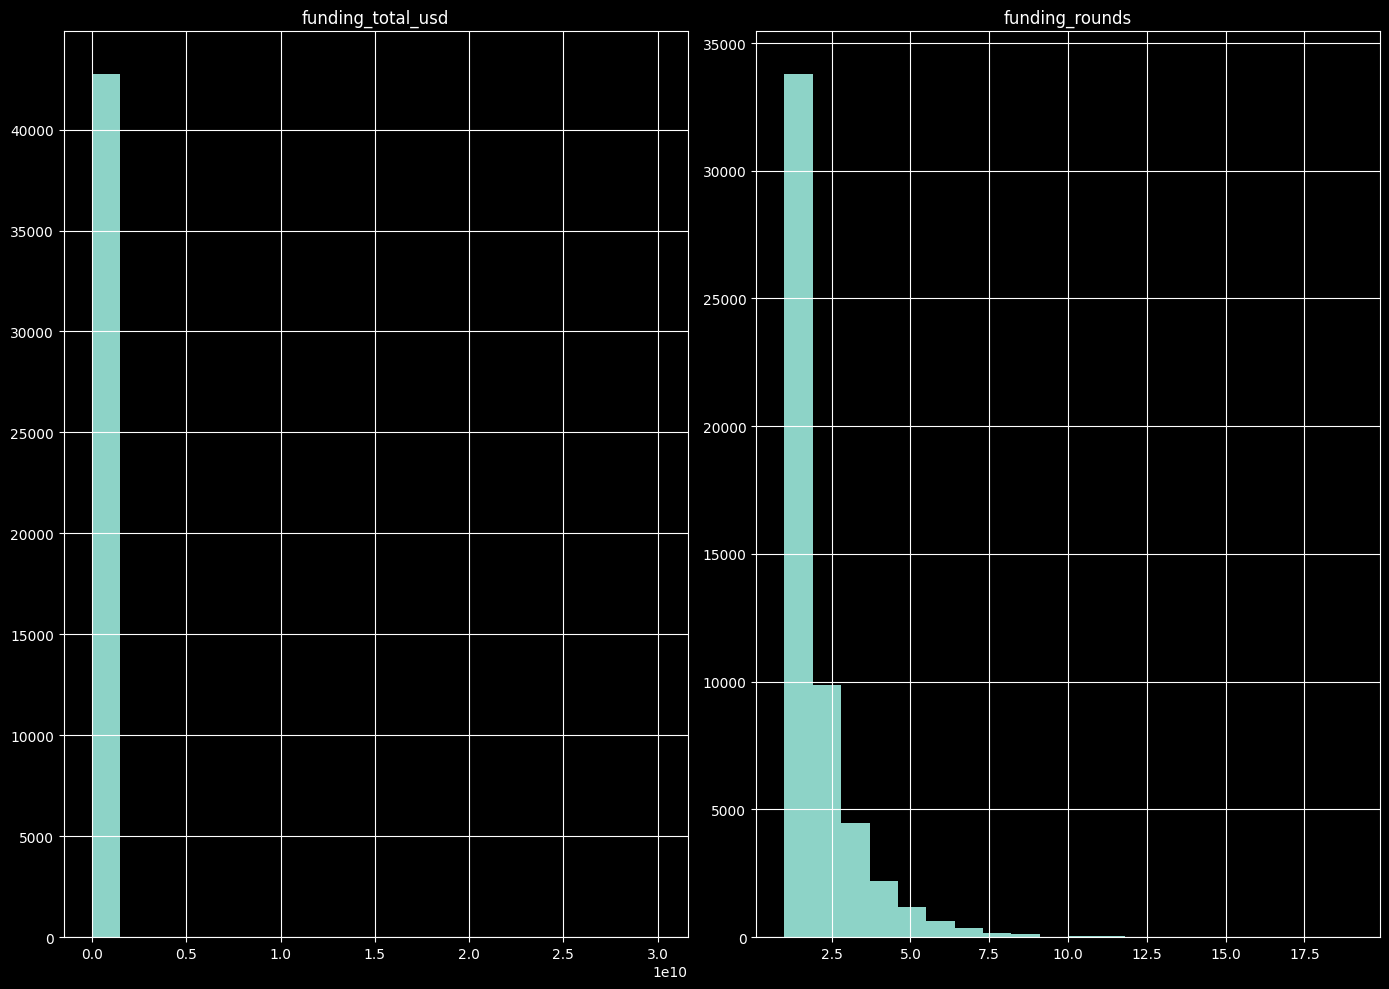

In [19]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

df[numeric_columns].hist(bins=20, figsize=(14, 10))
plt.tight_layout()
plt.show()

Видно жирнохвостовое распределение в обоих признаках. Оба графика пока соотвествуют здравому смыслу.
- **Размер финансирования** - находится в пределах 3 млрд. USD, сумма большая, но вполне реальная. Медийное значение - 2 млн. USD, среднее - 19 млн. USD
- **Количество райндов финансирования** максимально значение 19 раундов является вполне возможным. Медийное значение - 1 раунд, среднее - 1.7.

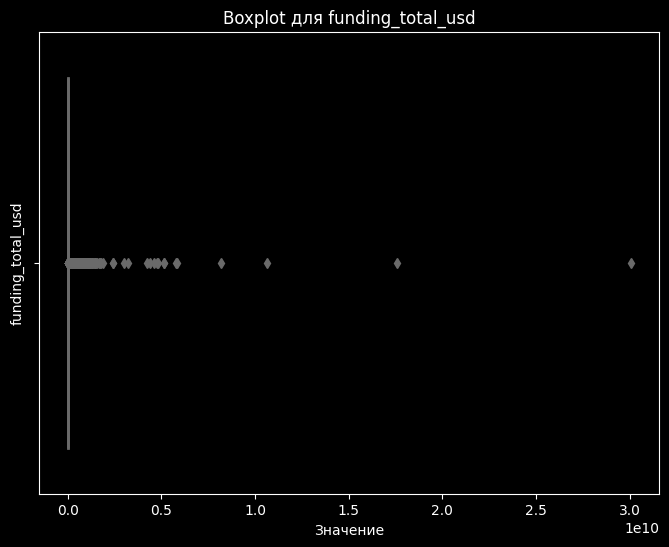

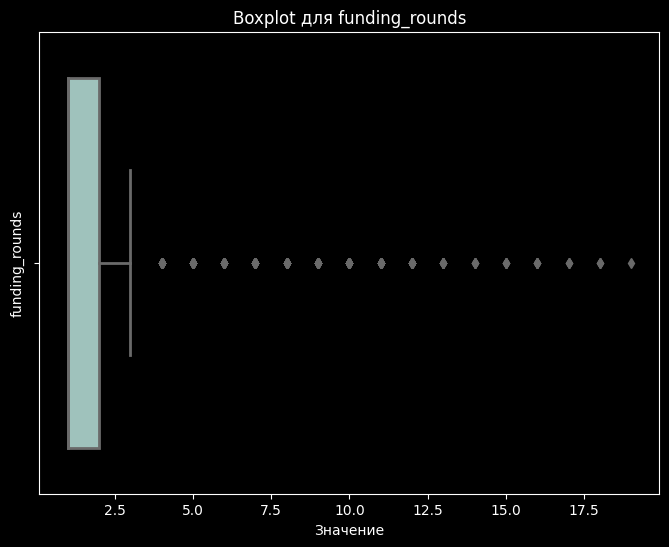

In [23]:
for column in numeric_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[column], orient='h', linewidth=2, saturation=0.5)
    plt.title(f'Boxplot для {column}')
    plt.xlabel('Значение')
    plt.ylabel(column)
    plt.show()

Боксплот так же говорит о большом разбросе в числовых данных. При обучении моделей определённо нужно будет задействовать scaler.